In [2]:
pip install tensorflow keras albumentations opencv-python numpy matplotlib --user

In [ ]:
pip install --user albumentations numpy==1.26.4

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --------------- Dataset Paths ---------------
dataset_path = "/content/drive/MyDrive/FYP_work/DecayDataSrc/Teeth_Dataset/augmented"
image_dir = os.path.join(dataset_path, "Images1")
mask_dir = os.path.join(dataset_path, "Masks1")

# --------------- Data Preparation ---------------
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

assert len(image_paths) == len(mask_paths), "Mismatch in number of images and masks!"

# Train-Validation Split
split = int(0.8 * len(image_paths))
train_images, val_images = image_paths[:split], image_paths[split:]
train_masks, val_masks = mask_paths[:split], mask_paths[split:]

# --------------- Data Generator ---------------
class TeethDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, image_size=(256, 256), augment=True, class_weighting=True, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.class_weighting = class_weighting
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

        self.augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.GaussianBlur(p=0.3),
            A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-10, 10), p=0.5),
            A.RandomCrop(height=256, width=256, p=0.7)
        ])

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_paths[k] for k in indexes]
        batch_masks = [self.mask_paths[k] for k in indexes]
        images, masks = self.__data_generation(batch_images, batch_masks)
        return np.array(images), np.array(masks)

    def __data_generation(self, batch_images, batch_masks):
        images, masks = [], []
        for img_path, mask_path in zip(batch_images, batch_masks):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.image_size) / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.image_size) / 255.0
            mask = np.where(mask >= 0.5, 1, 0).astype(np.uint8)

            if self.augment:
                augmented = self.augmentation(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            images.append(np.expand_dims(img, axis=-1))
            masks.append(np.expand_dims(mask, axis=-1))

        images, masks = np.array(images), np.array(masks)

        if self.class_weighting:
            mask_weights = np.where(masks > 0.5, 2.0, 1.0)
            masks = masks * mask_weights

        return images, masks

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# --------------- Loss Functions ---------------
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return 1 - dice_coefficient(y_true, y_pred)

def weighted_focal_loss(y_true, y_pred, alpha=0.95, gamma=2.0):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -alpha * (1 - y_pred)**gamma * y_true * K.log(y_pred) - (1-alpha) * (y_pred**gamma) * (1-y_true) * K.log(1-y_pred)
    return K.mean(loss)

def tversky_loss(y_true, y_pred, smooth=1e-6, alpha=0.7, beta=0.3):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum((1 - y_true_f) * y_pred_f)
    FN = K.sum(y_true_f * (1 - y_pred_f))
    return 1 - (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)

def combined_loss(y_true, y_pred):
    return 0.4 * dice_loss(y_true, y_pred) + 0.3 * weighted_focal_loss(y_true, y_pred) + 0.3 * tversky_loss(y_true, y_pred)

# --------------- Model (U-Net) ---------------
def build_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# --------------- Training ---------------
model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=combined_loss,
              metrics=[dice_coefficient])

checkpoint_path = '/content/sample_data/unet_best_model.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

train_gen = TeethDataGenerator(train_images, train_masks, batch_size=2, augment=True)
val_gen = TeethDataGenerator(val_images, val_masks, batch_size=2, augment=False)

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    callbacks=[checkpoint, reduce_lr])

# --------------- Load Best Model ---------------
best_model = load_model(checkpoint_path, custom_objects={
    'combined_loss': combined_loss,
    'dice_coefficient': dice_coefficient
})

# --------------- Evaluate and Classification Report ---------------
# Prepare validation data
val_gen = TeethDataGenerator(val_images, val_masks, batch_size=1, augment=False, class_weighting=False)
preds = best_model.predict(val_gen, verbose=1)
preds_binary = (preds > 0.5).astype(np.uint8)

# Load ground truth masks
true_masks = []
for path in val_masks:
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = np.where(mask >= 127, 1, 0)
    true_masks.append(mask)
true_masks = np.expand_dims(np.array(true_masks), axis=-1)

# Flatten
y_true = true_masks.flatten()
y_pred = preds_binary.flatten()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Background", "Teeth"]))


Mounted at /content/drive
Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coefficient: 0.6604 - loss: 0.2726
Epoch 1: val_dice_coefficient improved from -inf to 0.94026, saving model to /content/sample_data/unet_best_model.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - dice_coefficient: 0.6611 - loss: 0.2721 - val_dice_coefficient: 0.9403 - val_loss: 0.0464 - learning_rate: 5.0000e-05
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - dice_coefficient: 0.9762 - loss: 0.0169
Epoch 2: val_dice_coefficient did not improve from 0.94026
232/232 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - dice_coefficient: 0.9762 - loss: 0.0169 - val_dice_coefficient: 0.8667 - val_loss: 0.1019 - learning_rate: 5.0000e-05
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - dice_coefficient: 0.9946 - loss: -0.0026
Epoch 3: val_dice_coefficient improved from 0.94026 to 0.94158, saving model to /content/sample_data/unet_best_model.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - dice_coeffi

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


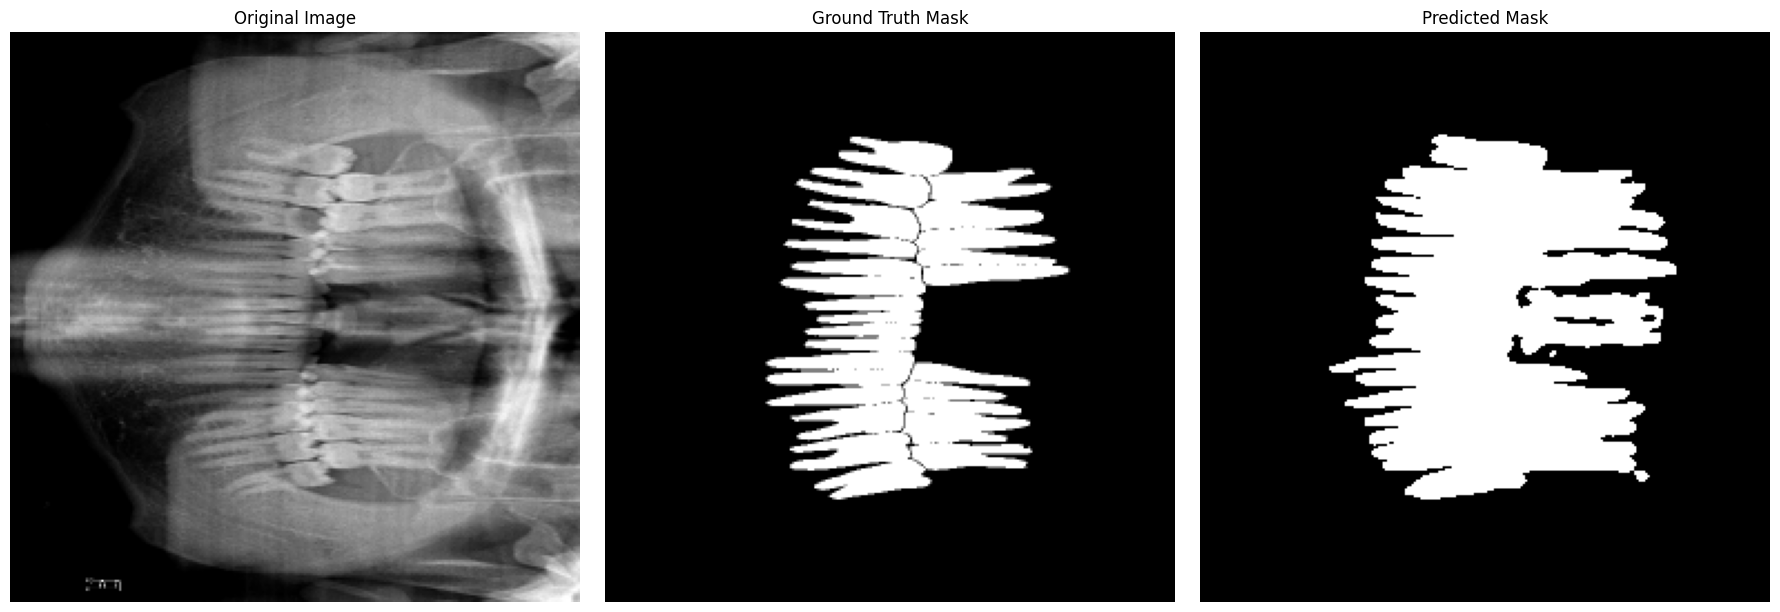

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image and mask
img_path = val_images[0]
mask_path = val_masks[0]

# 1. Read and preprocess image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # (512,512)
img = cv2.resize(img, (256, 256))                   # resize to (256,256)
img = img / 255.0                                   # normalize
img = np.expand_dims(img, axis=-1)                  # (256,256,1)

# 2. Read and preprocess mask
true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(true_mask, (256, 256))
true_mask = true_mask / 255.0
true_mask = np.expand_dims(true_mask, axis=-1)

# 3. Predict
pred_mask = model.predict(np.expand_dims(img, axis=0))[0]   # shape (256,256,1)
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# 4. Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask.squeeze(), cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()
